<a href="https://colab.research.google.com/github/bulla1009/RainfallEstimation/blob/main/PLOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/IGCAR/plotting


/content/drive/MyDrive/IGCAR/plotting


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00


In [ ]:
%ls

plotting_vals.csv


In [ ]:
import netCDF4 as nc

In [ ]:
%cd ..

/content/drive/MyDrive/IGCAR


In [ ]:
ncfile = nc.Dataset('test.nc')

In [ ]:
import math
import pandas as pd
elevation = ncfile.variables['Elevation_Info'][0,0]

def calculate_destination(lat, lon, distance, bearing):
    R = 6371000
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    bearing_rad = math.radians(bearing)
    dest_lat_rad = math.asin(math.sin(lat_rad) * math.cos(distance / R) + math.cos(lat_rad) * math.sin(distance / R) * math.cos(bearing_rad))
    dest_lon_rad = lon_rad + math.atan2(math.sin(bearing_rad) * math.sin(distance / R) * math.cos(lat_rad),math.cos(distance / R) - math.sin(lat_rad) * math.sin(dest_lat_rad))

    dest_lat = math.degrees(dest_lat_rad)
    dest_lon = math.degrees(dest_lon_rad)

    return dest_lat, dest_lon
lat = []
lon = []
reflectivity = []
igcar_lat = 12.5788
igcar_lon = 80.1832
for i in range(360):
    for j in range(1,1663):
        lat_dest,lon_dest = calculate_destination(igcar_lat,igcar_lon,150*j,i)
        lat.append(lat_dest)
        lon.append(lon_dest)
        reflectivity.append(ncfile.variables['Reflectivity_Horizontal'][0][i][j-1])

df = pd.DataFrame()
df['lat'] = lat
df['lon'] = lon
df['value'] = reflectivity
df.to_csv('latlon.csv')

In [ ]:
df = pd.read('latlon.csv')
import numpy as np
import numpy.ma as ma
cnt = 0
for i in range(len(df)):
  if ma.is_masked(df['value'][i]) :
    cnt += 1
    df.loc[i,'value'] = 0

for i in range(len(df)):
  if df['value'][i] == np.nan :
    cnt += 1
    df.loc[i,'value'] = 0
print(cnt)

420606


In [ ]:
print(len(df))

598320


In [ ]:
df['value'] = df['value'].astype(float)

In [ ]:
!pip install Basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


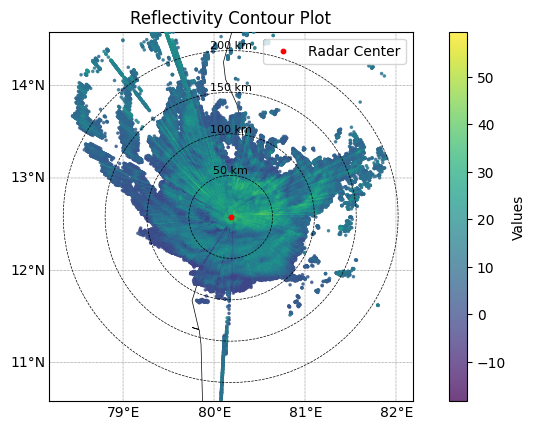

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_selected, lats, lons, and values are already defined as in your example
df_selected = df[df['value'] != 0]
lats = df_selected['lat'].values
lons = df_selected['lon'].values
values = df_selected['value'].values

# Correct coordinates for the radar center
igcar_lon, igcar_lat = 80.1832, 12.5788

# Create a Basemap instance with a zoomed-in view
m = Basemap(projection='mill', llcrnrlat=igcar_lat-2, urcrnrlat=igcar_lat+2,
            llcrnrlon=igcar_lon-2, urcrnrlon=igcar_lon+2, resolution='l')

# Plot points with color based on value
sc = m.scatter(lons, lats, latlon=True, c=values, cmap='viridis', marker='.', s=10, zorder=5, alpha=0.75)

# Plotting the radar center
m.scatter(igcar_lon, igcar_lat, latlon=True, c='red', marker='o', s=10, zorder=10, label='Radar Center')

# Mark angles
angles = np.arange(0, 360, 30)  # Angles in degrees
for angle in angles:
    end_lon = igcar_lon + 0.5 * np.cos(np.deg2rad(angle))  # Adjust for visibility
    end_lat = igcar_lat + 0.5 * np.sin(np.deg2rad(angle))  # Adjust for visibility
    x, y = m(end_lon, end_lat)
    plt.text(x, y, f'{angle}°', horizontalalignment='center', verticalalignment='center', color='green', fontsize=8)

# Draw coastlines and political boundaries
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)

# Draw parallels and meridians (gridlines) with labels
parallels = m.drawparallels(np.arange(-90, 91, 1), labels=[1, 0, 0, 0], color='gray', linewidth=0.5, dashes=[1, 1], zorder=1)
meridians = m.drawmeridians(np.arange(-180, 181, 1), labels=[0, 0, 0, 1], color='gray', linewidth=0.5, dashes=[1, 1], zorder=1)

# Draw concentric circles for range above the plot
ranges = [50, 100, 150, 200]  # Distances in kilometers
for r in ranges:
    circle = m.tissot(igcar_lon, igcar_lat, r / 111.32, 100, facecolor='none', edgecolor='black', linestyle='--', linewidth=0.5, zorder=15)
    x, y = m(igcar_lon, igcar_lat + r / 111.32)
    plt.text(x, y + 0.1, f'{r} km', horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=8, zorder=20)

# Add colorbar
cbar = m.colorbar(sc, location='right', pad='10%')
cbar.set_label('Values')

# Add title and show the plot
plt.title("Reflectivity Contour Plot")
plt.legend(loc='upper right')
plt.show()
